In [ ]:
import os
from disentangle.data_loader.evaluation_dloader import EvaluationDloader, GridAlignement

# from disentangle.data_loader.patch_index_manager import GridAlignement
from disentangle.nets.model_utils import create_model
from nis2pyr.reader import read_nd2file
from disentangle.config_utils import load_config
from matplotlib_scalebar.scalebar import ScaleBar

import nd2
import glob
import torch
import numpy as np


def load_7D(fpath):
    print(f"Loading from {fpath}")
    with nd2.ND2File(fpath) as nd2file:
        data = read_nd2file(nd2file)
    return data


def get_best_checkpoint(ckpt_dir):
    output = []
    for filename in glob.glob(ckpt_dir + "/*_best.ckpt"):
        output.append(filename)
    assert len(output) == 1, "\n".join(output)
    return output[0]

In [ ]:
# ckpt_dir = "/group/jug/ashesh/training/disentangle/2407/D28-M3-S0-L0/16"
# ckpt_dir = "/group/jug/ashesh/training/disentangle/2407/D28-M3-S0-L0/22"
ckpt_dir = "/group/jug/ashesh/training/disentangle/2506/D28-M3-S0-L0/0"
data_dir = "/group/jug/ashesh/data/Elisa/test"
fnames = [x for x in sorted(os.listdir(data_dir)) if x.endswith("0001.nd2")]
datafile = os.path.join(data_dir, fnames[0])
# pixel resolution in nanometers
resolution_nm = 285

# the other puncta removal dataset.
# ckpt_dir = '/group/jug/ashesh/training/disentangle/2503/D28-M3-S0-L0/9'
# data_dir = '/group/jug/ashesh/data/struct_noise_Feb25/'
# from disentangle.core.tiff_reader import load_tiff
# data = load_tiff(datafile)
# data = data[:4096,1000:5096][None,]
# data.shape

# datafile = '/facility/imganfacusers/Ashesh/data_for_Ashesh_Feb_13/test_slice/DIF21_H9_WT_2_DIV50_2_1-Stitched-1.tif'
batch_size = 8

In [ ]:
data = load_7D(datafile)
print(data.shape)
data = data[0, 0, :, 1, ..., 0]
print(data.shape)

Loading from /group/jug/ashesh/data/Elisa/test/DIF_17_Day_25_Untreated_1_4_0001.nd2
ND2 dimensions: {'Z': 21, 'C': 3, 'Y': 3056, 'X': 3056}; RGB: False; datatype: uint16; legacy: False
(1, 1, 21, 3, 3056, 3056, 1)
(21, 3056, 3056)


In [4]:
# import matplotlib.pyplot as plt
# plt.imshow(data[0,0,10,2,800:1600,800:1600,0])

In [5]:
# ch0 = load_tiff('/group/jug/ashesh/data/struct_noise_Feb25/ch0/10_c0.tif')
# ch1 = load_tiff('/group/jug/ashesh/data/struct_noise_Feb25/ch1/10_c1.tif')
# _,ax = plt.subplots(1,2, figsize=(10,5))
# ax[0].imshow(ch0)
# ax[1].imshow(ch1)

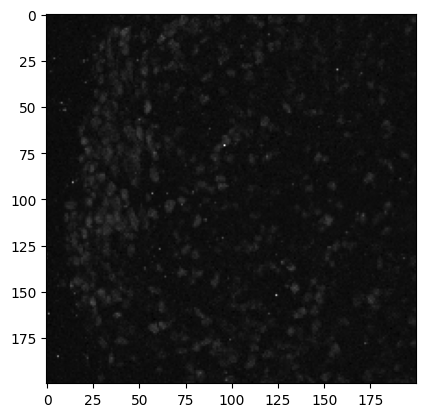

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(data[10, ::5, ::5][200:400, 100:300], cmap="gray")

In [7]:
config = load_config(ckpt_dir)

In [ ]:
test_z_idx = 10
test_data = data[test_z_idx : test_z_idx + 1].copy()
test_data = test_data.astype(np.float32)
test_data -= config.data.background_values[0]

In [9]:
data.shape

(21, 3056, 3056)

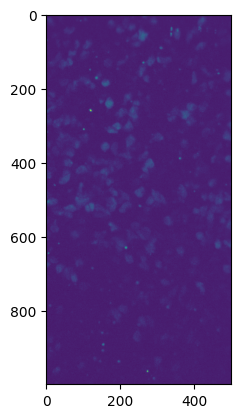

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(data[10][1500:2500, 1000:1500])

## Mean/Stdev

In [ ]:
from disentangle.data_loader.multicrops_dset import l2


def sample_crop(sz):
    t = np.random.randint(0, len(test_data))
    x = np.random.randint(0, test_data.shape[1] - sz)
    y = np.random.randint(0, test_data.shape[2] - sz)
    crop = test_data[t, x : x + sz, y : y + sz]
    return crop


def compute_mean_std():
    mean_inp = []
    std_inp = []
    for _ in range(30000):
        crop = sample_crop(config.data.image_size)
        mean_inp.append(np.mean(crop))
        std_inp.append(np.std(crop))

    output_mean = {}
    output_std = {}
    output_mean["input"] = np.array([np.mean(mean_inp)]).reshape(-1, 1, 1, 1)
    output_std["input"] = np.array([l2(std_inp)]).reshape(-1, 1, 1, 1)

    output_mean["target"] = np.tile(output_mean["input"], (1, 2, 1, 1))
    output_std["target"] = np.tile(output_std["input"], (1, 2, 1, 1))
    return output_mean, output_std


In [12]:
mean_dict, std_dict = compute_mean_std()

In [ ]:
model = create_model(config, mean_dict.copy(), std_dict.copy())

Noise model Ch1: /home/ashesh.ashesh/training/noise_model/2407/3/GMMNoiseModel_N2V_Elisa-n2v_input__6_4_Clip0.0-1.0_Sig0.125_UpNone_Norm0_bootstrap.npz
Noise model Ch2: /home/ashesh.ashesh/training/noise_model/2407/3/GMMNoiseModel_N2V_Elisa-n2v_input__6_4_Clip0.0-1.0_Sig0.125_UpNone_Norm0_bootstrap.npz
[GaussianMixtureNoiseModel] min_sigma: 0.125
[GaussianMixtureNoiseModel] min_sigma: 0.125
[DisentNoiseModel] Nmodels count:2
[3, 3] [1, 1]
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[BottomUpLayer] McEnabled:0 
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[3, 3] [1, 1]
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[TopDownLayer] normalize_latent_factor:1.0
[3, 3] [1, 1]
[GaussianLikelihood] PredLVar:None LowBLVar:-5
[LadderVAE] 

In [ ]:
ckpt_fpath = get_best_checkpoint(ckpt_dir)
print("Loading checkpoint from", ckpt_fpath)
checkpoint = torch.load(ckpt_fpath)

_ = model.load_state_dict(checkpoint["state_dict"], strict=False)
model.eval()
_ = model.cuda()
model.set_params_to_same_device_as(torch.Tensor(1).cuda())

print("Loading from epoch", checkpoint["epoch"])

Loading checkpoint from /group/jug/ashesh/training/disentangle/2506/D28-M3-S0-L0/0/BaselineVAECL_best.ckpt
Loading from epoch 8


In [ ]:
def normalizer(x):
    return (x - mean_dict["input"].squeeze()) / std_dict["input"].squeeze()

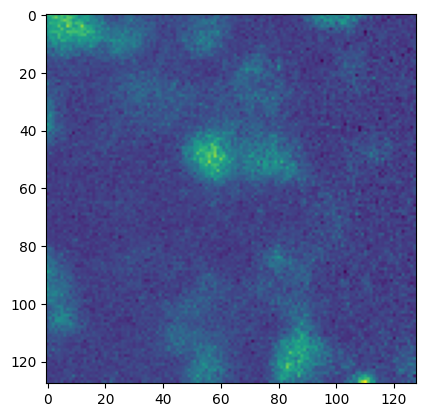

In [ ]:
inp_patch = test_data[0, 1800:1928, 1500:1628]
plt.imshow(inp_patch)

In [17]:
model.reset_for_different_output_size(inp_patch.shape[0])
model.mode_pred = True

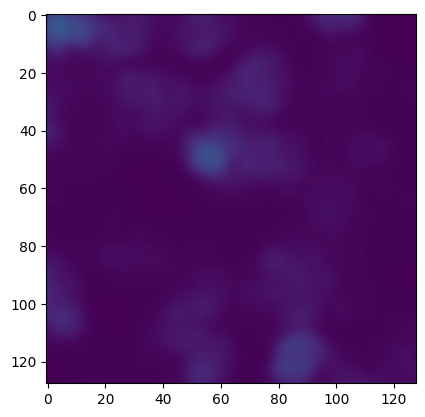

In [ ]:
inp = normalizer(inp_patch)
with torch.no_grad():
    out = model(torch.Tensor(inp[None, None]).cuda())
out[0].shape
plt.imshow(out[0][0, 1].cpu().numpy(), vmax=30)

In [ ]:
dset = EvaluationDloader(
    test_data, normalizer, lambda x: x, config.data.image_size, config.data.image_size // 4, GridAlignement.Center
)

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm


def get_dset_predictions(model, dset, batch_size, mmse_count=1, num_workers=4):
    model.reset_for_different_output_size(dset[0].shape[0])

    dloader = DataLoader(dset, pin_memory=False, num_workers=num_workers, shuffle=False, batch_size=batch_size)
    predictions = []
    predictions_std = []
    with torch.no_grad():
        for inp in tqdm(dloader):
            inp = inp.cuda()
            recon_img_list = []
            for mmse_idx in range(mmse_count):
                imgs, _ = model(inp)
                recon_img_list.append(imgs.cpu()[None])

            samples = torch.cat(recon_img_list, dim=0)
            mmse_imgs = torch.mean(samples, dim=0)
            mmse_std = torch.std(samples, dim=0)
            predictions.append(mmse_imgs.cpu().numpy())
            predictions_std.append(mmse_std.cpu().numpy())
    return np.concatenate(predictions, axis=0), np.concatenate(predictions_std, axis=0)


In [ ]:
pred_tiled, pred_std = get_dset_predictions(model, dset, batch_size * 10, mmse_count=1, num_workers=4)

  0%|          | 0/457 [00:00<?, ?it/s]/tmp/ipykernel_23861/2024862346.py:20: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/native/ReduceOps.cpp:1839.)
  mmse_std = torch.std(samples, dim=0)
100%|██████████| 457/457 [00:46<00:00,  9.85it/s]


In [ ]:
import numpy as np

# from disentangle.data_loader.multifile_dset import MultiFileDset
# from disentangle.data_loader.patch_index_manager import GridAlignement


class PatchLocation:
    """
    Encapsulates t_idx and spatial location.
    """

    def __init__(self, h_idx_range, w_idx_range, t_idx):
        self.t = t_idx
        self.h_start, self.h_end = h_idx_range
        self.w_start, self.w_end = w_idx_range

    def __str__(self):
        msg = f"T:{self.t} [{self.h_start}-{self.h_end}) [{self.w_start}-{self.w_end}) "
        return msg


def _get_location(extra_padding, hwt, pred_h, pred_w):
    h_start, w_start, t_idx = hwt
    h_start -= extra_padding
    h_end = h_start + pred_h
    w_start -= extra_padding
    w_end = w_start + pred_w
    return PatchLocation((h_start, h_end), (w_start, w_end), t_idx)


def get_location_from_idx(dset, dset_input_idx, pred_h, pred_w):
    """
    For a given idx of the dataset, it returns where exactly in the dataset, does this prediction lies.
    Note that this prediction also has padded pixels and so a subset of it will be used in the final prediction.
    Which time frame, which spatial location (h_start, h_end, w_start,w_end)
    Args:
        dset:
        dset_input_idx:
        pred_h:
        pred_w:

    Returns:
    """
    extra_padding = dset.per_side_overlap_pixelcount()
    htw = dset.idx_manager.hwt_from_idx(dset_input_idx, grid_size=dset.get_grid_size())
    loc = _get_location(extra_padding, htw, pred_h, pred_w)
    return loc


def set_skip_boundary_pixels_mask(mask, loc, skip_count):
    if skip_count == 0:
        return mask
    assert skip_count > 0
    assert loc.h_end - skip_count >= 0
    assert loc.w_end - skip_count >= 0
    mask[loc.t, :, loc.h_start : loc.h_start + skip_count, loc.w_start : loc.w_end] = False
    mask[loc.t, :, loc.h_end - skip_count : loc.h_end, loc.w_start : loc.w_end] = False
    mask[loc.t, :, loc.h_start : loc.h_end, loc.w_start : loc.w_start + skip_count] = False
    mask[loc.t, :, loc.h_start : loc.h_end, loc.w_end - skip_count : loc.w_end] = False


def set_skip_central_pixels_mask(mask, loc, skip_count):
    if skip_count == 0:
        return mask
    assert skip_count > 0
    h_mid = (loc.h_start + loc.h_end) // 2
    w_mid = (loc.w_start + loc.w_end) // 2
    l_skip = skip_count // 2
    r_skip = skip_count - l_skip
    mask[loc.t, :, h_mid - l_skip : h_mid + r_skip, w_mid - l_skip : w_mid + r_skip] = False


def stitched_prediction_mask(dset, padded_patch_shape, skip_boundary_pixel_count, skip_central_pixel_count):
    """
    Returns the boolean matrix. It will be 0 if it lies either in skipped boundaries or skipped central pixels
    Args:
        dset:
        padded_patch_shape:
        skip_boundary_pixel_count:
        skip_central_pixel_count:

    Returns:
    """
    N, H, W, C = dset.get_data_shape()
    mask = np.full((N, C, H, W), True)
    hN, wN = padded_patch_shape
    for dset_input_idx in range(len(dset)):
        loc = get_location_from_idx(dset, dset_input_idx, hN, wN)
        set_skip_boundary_pixels_mask(mask, loc, skip_boundary_pixel_count)
        set_skip_central_pixels_mask(mask, loc, skip_central_pixel_count)

    old_img_sz = dset.get_img_sz()
    dset.set_img_sz(dset._img_sz_for_hw)
    mask = stitch_predictions(mask, dset)
    dset.set_img_sz(old_img_sz)
    return mask


def remove_pad(pred, loc, extra_padding, frame_shape, on_h_boundary, on_w_boundary, full_prediction=False):
    if extra_padding > 0:
        h_s = extra_padding

        # rows
        h_N = frame_shape[0]
        if loc.h_end >= h_N:
            assert loc.h_end - extra_padding <= h_N or full_prediction
            if full_prediction:
                h_e = loc.h_end - h_N
            else:
                h_e = extra_padding
        elif on_h_boundary and full_prediction:
            h_e = 0
        else:
            h_e = extra_padding

        w_s = extra_padding

        # columns
        w_N = frame_shape[1]
        if loc.w_end >= w_N:
            assert loc.w_end - extra_padding <= w_N or full_prediction
            if full_prediction:
                w_e = loc.w_end - w_N
            else:
                w_e = extra_padding
        elif on_w_boundary and full_prediction:
            w_e = 0
        else:
            w_e = extra_padding

        if h_e > 0 and w_e > 0:
            return pred[h_s:-h_e, w_s:-w_e]
        elif h_e > 0:
            return pred[h_s:-h_e, w_s:]
        elif w_e > 0:
            return pred[h_s:, w_s:-w_e]
        elif h_e == 0 and w_e == 0:
            return pred[h_s:, w_s:]
    return pred


def update_loc_for_final_insertion_full_pred(loc, extra_padding, frame_shape, on_h_boundary, on_w_boundary):
    loc.h_start += extra_padding
    loc.w_start += extra_padding
    # rows
    h_N = frame_shape[0]
    if loc.h_end >= h_N:
        loc.h_end = h_N
    elif on_h_boundary:
        assert loc.h_end == h_N
    else:
        loc.h_end -= extra_padding

    w_N = frame_shape[1]
    if loc.w_end >= w_N:
        loc.w_end = w_N
    elif on_w_boundary:
        assert loc.w_end == w_N
    else:
        loc.w_end -= extra_padding
    return loc


def update_loc_for_final_insertion(loc, extra_padding):
    loc.h_start += extra_padding
    loc.w_start += extra_padding
    loc.h_end -= extra_padding
    loc.w_end -= extra_padding
    return loc


def stitch_predictions(predictions, dset, full_prediction=False):
    """
    Args:
        smoothening_pixelcount: number of pixels which can be interpolated
    """
    # if isinstance(dset, MultiFileDset):
    #     cum_count = 0
    #     output = []
    #     for dset in dset.dsets:
    #         cnt = dset.idx_manager.grid_count()
    #         output.append(
    #             stitch_predictions(predictions[cum_count:cum_count + cnt], dset, full_prediction=full_prediction))
    #         cum_count += cnt
    #     return output

    # else:
    extra_padding = dset.per_side_overlap_pixelcount()
    # if there are more channels, use all of them.
    shape = list(dset.get_data_shape())
    shape[-1] = max(shape[-1], predictions.shape[1])

    output = np.zeros(shape, dtype=predictions.dtype)
    frame_shape = dset.get_data_shape()[1:3]
    for dset_input_idx in range(predictions.shape[0]):
        loc = get_location_from_idx(dset, dset_input_idx, predictions.shape[-2], predictions.shape[-1])

        cropped_pred_list = []
        for ch_idx in range(predictions.shape[1]):
            # class i
            cropped_pred_i = remove_pad(
                predictions[dset_input_idx, ch_idx],
                loc,
                extra_padding,
                frame_shape,
                dset.idx_manager.on_bottom_boundary(dset_input_idx),
                dset.idx_manager.on_right_boundary(dset_input_idx),
                full_prediction=full_prediction,
            )
            cropped_pred_list.append(cropped_pred_i)

        if full_prediction:
            final_loc = update_loc_for_final_insertion_full_pred(
                loc,
                extra_padding,
                frame_shape,
                dset.idx_manager.on_bottom_boundary(dset_input_idx),
                dset.idx_manager.on_right_boundary(dset_input_idx),
            )
        else:
            final_loc = update_loc_for_final_insertion(loc, extra_padding)

        for ch_idx in range(predictions.shape[1]):
            output[final_loc.t, final_loc.h_start : final_loc.h_end, final_loc.w_start : final_loc.w_end, ch_idx] = (
                cropped_pred_list[ch_idx]
            )

    return output


def remove_terminal_zeros(pred):
    he = 1
    we = 1
    while pred[:, -he:, -we:].std() == 0:
        he += 1
        we += 1
    he -= 1
    we -= 1
    if he == 0 and we == 0:
        return pred
    return pred[:, :-he, :-we]


In [ ]:
mean_dict["target"].shape

(1, 2, 1, 1)

In [ ]:
# from disentangle.analysis.stitch_prediction import stitch_predictions
pred = stitch_predictions(pred_tiled, dset)
pred = pred * std_dict["target"].squeeze().reshape(1, 1, 1, 2) + mean_dict["target"].squeeze().reshape(1, 1, 1, 2)
pred.shape


(1, 3056, 3056, 2)

In [ ]:
test_data.shape


(1, 3056, 3056)

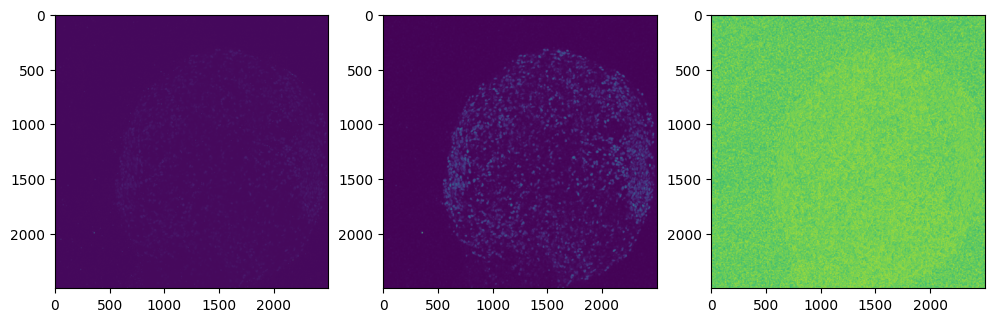

In [ ]:
_, ax = plt.subplots(figsize=(12, 4), ncols=3)
hs = 0
he = 2500
ws = 0
we = 2500
ax[0].imshow(test_data[0, hs:he, ws:we])
ax[1].imshow(pred[0, hs:he, ws:we, 1])
ax[2].imshow(pred[0, hs:he, ws:we, 0])

In [27]:
# from disentangle.analysis.plot_utils import clean_ax
# from matplotlib.colors import LogNorm

# _,ax = plt.subplots(figsize=(16,8),ncols=4,nrows=2)
# ax= ax.reshape(-1,)
# t_idx =0
# sz = 300
# for i in range(len(ax)//2):
#     hs = np.random.randint(0, test_data.shape[1] - sz)
#     ws = np.random.randint(0, test_data.shape[2] - sz)
#     ax[2*i].imshow(test_data[t_idx,hs:hs+sz,ws:ws+sz], vmax=130)
#     ax[2*i+1].imshow(pred[t_idx,hs:hs+sz,ws:ws+sz,1])
#     ax[2*i].set_title(f'Input, {t_idx,hs,ws}')
#     ax[2*i+1].set_title('Puncta Removed')
# clean_ax(ax)

## Nature methods plot

In [28]:
# fnames:7, [8,1500:2700,500:2200]
# fnames:8, [7/8/9/10,:1400,:800] => good
# fnames:8, [7,1000:2400,800:2200]
# fnames[13], [9/11,900:1500,1000:2400]
# fnames[14], [9,2400:3800,700:2000]
# fnames[15] [9,2200:4500,500:1500]
# fnames[15] [9,300:2400,1000:2800]
# fnames[15] [9,500:2400,2800:3900]
# fnames[15] [9, 2500:4500,600:1500]
# fnames[16] [9,400:1500,500:1700]

In [ ]:
import os

output_dir = os.path.join("/group/jug/ashesh/naturemethods/puncta/", os.path.basename(datafile).replace(".nd2", ""))
os.makedirs(output_dir, exist_ok=True)
output_dir

'/group/jug/ashesh/naturemethods/puncta/DIF_17_Day_25_Untreated_1_4_0001'

z.10_region.400-1400_sz.1200


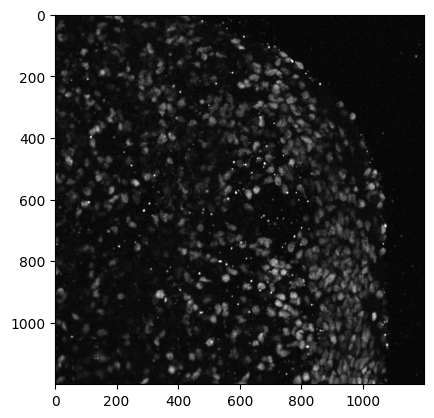

In [40]:
save_to_file = True
# hs_region = 400
# ws_region = 500
hs_region = 400
ws_region = 1400
sz = 1200
inp_region = test_data[0, hs_region : hs_region + sz, ws_region : ws_region + sz]
pred_region = pred[0, hs_region : hs_region + sz, ws_region : ws_region + sz, 1]
vmin = int(np.floor(pred_region.min()))
vmax = int(np.ceil(pred_region.max()))
vmin, vmax
plt.imshow(inp_region, vmax=vmax, vmin=vmin, cmap="gray")
if save_to_file:
    fname_prefix = f"z.{test_z_idx}_region.{hs_region}-{ws_region}_sz.{sz}"
    print(fname_prefix)

Saved to /group/jug/ashesh/naturemethods/puncta/DIF_17_Day_25_Untreated_1_4_0001/z.10_region.400-1400_sz.1200_full_region.pdf


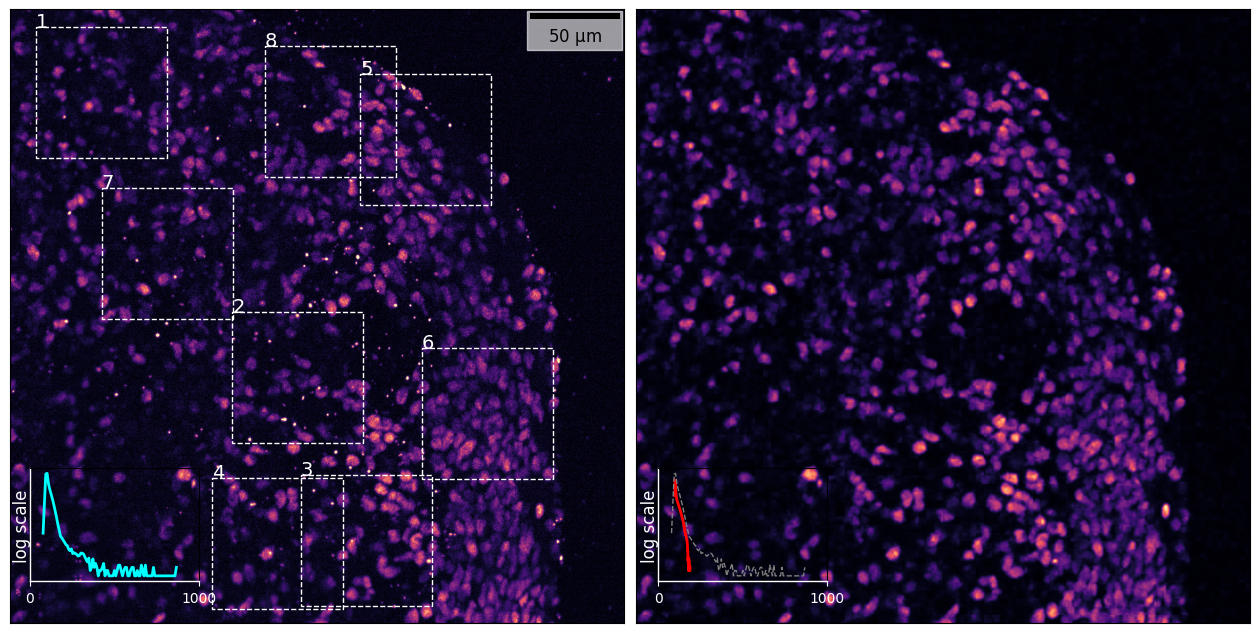

In [44]:
# np.save(f'inp.npy', inp_region)
# np.save(f'pred.npy', pred_region)

import matplotlib.patches as patches
from disentangle.analysis.plot_utils import add_pixel_kde
from disentangle.analysis.plot_utils import clean_ax
from disentangle.analysis.plot_utils import clean_for_xaxis_plot, add_subplot_axes


def hist_plot(ax, data, color="cyan", linewidth=2, **kwargs):
    bins = np.histogram_bin_edges(data.flatten(), bins=100)
    count = np.histogram(data.flatten(), bins=bins)[0]

    ax.plot(bins[:-1], np.log(1 + count), color=color, linewidth=linewidth, **kwargs)
    ax.set_xlim([0, 1000])
    xticks = ax.get_xticks()
    ax.set_xticks([xticks[0], xticks[-1]])
    ax.set_yticks([])

    # clean_for_xaxis_plot(ax)
    # ax.set_ylabel('log', fontsize=12, color='white')


# color_ch_list = ['goldenrod', 'cyan']
# color_pred = 'red'
insetplot_xmax_value = 1000
insetplot_xmin_value = 0
inset_min_labelsize = 10

cropsz = 256

_, ax = plt.subplots(figsize=(16, 8), ncols=2, nrows=1)
puncta_mask = inp_region > vmax
ax[0].imshow(inp_region, vmin=vmin, vmax=vmax, cmap="magma")

# inset
inset_ax = add_subplot_axes(ax[0], [0.035, 0.03, 0.3, 0.2], facecolor="None", min_labelsize=inset_min_labelsize)
inset_ax.tick_params(axis="x", colors="white")
hist_plot(inset_ax, inp_region, color="cyan")
inset_ax.spines["bottom"].set_linewidth(1)
inset_ax.spines["bottom"].set_color("white")
inset_ax.spines["left"].set_linewidth(1)
inset_ax.spines["left"].set_color("white")
inset_ax.set_yticks([])
inset_ax.text(-0.1, 0.2, "log scale", fontsize=12, color="white", rotation=90, transform=inset_ax.transAxes)


new_mask = np.tile(puncta_mask[:, :, None], (1, 1, 3))
new_mask[..., 1] = 0
new_mask[..., 2] = 0
new_mask = new_mask.astype(np.uint8) * 255
# ax[0].imshow(new_mask, alpha=1)
ax[1].imshow(pred_region, cmap="magma")
# inset
inset_ax = add_subplot_axes(ax[1], [-0.05, 0.03, 0.3, 0.2], facecolor="None", min_labelsize=inset_min_labelsize)
inset_ax.tick_params(axis="x", colors="white")
hist_plot(inset_ax, pred_region, color="red")
hist_plot(inset_ax, inp_region, color="gray", linewidth=1, linestyle="--")

inset_ax.spines["bottom"].set_linewidth(1)
inset_ax.spines["bottom"].set_color("white")
inset_ax.spines["left"].set_linewidth(1)
inset_ax.spines["left"].set_color("white")

inset_ax.set_yticks([])
inset_ax.text(-0.1, 0.2, "log scale", fontsize=12, color="white", rotation=90, transform=inset_ax.transAxes)

clean_ax(ax)
# hw_arr= [(900, 310),
# (628, 313),
# (758, 80),
# (605, 49),
# (424, 815),
# (449, 541),
# (92, 684),
# (587,844)
# ]
hw_arr = [
    (35, 50),
    (591, 434),
    (911, 568),
    (917, 395),
    (127, 684),
    (662, 804),
    (350, 179),
    (72, 498),
]
for i, loc in enumerate(hw_arr):
    (h_s, w_s) = loc
    rect = patches.Rectangle((w_s, h_s), cropsz, cropsz, linewidth=1, edgecolor="w", facecolor="none", linestyle="--")
    ax[0].add_patch(rect)
    # add a number at the top left of the rectangle
    ax[0].text(w_s, h_s, str(i + 1), color="white", fontsize=14)

scalebar = ScaleBar(
    resolution_nm,
    "nm",
    # length_fraction=0.1,
    box_alpha=0.6,
    frameon=True,
    location="upper right",
    font_properties={"size": 12},
)

ax[0].add_artist(scalebar)

# adjust the subplot gap
plt.subplots_adjust(wspace=0.02, hspace=0.02)
if save_to_file:
    fpath = os.path.join(output_dir, f"{fname_prefix}_full_region.pdf")
    # save with high dpi
    plt.savefig(fpath, dpi=100)
    print("Saved to", fpath)

In [45]:
import seaborn as sns

# sns.kdeplot(data=inp_region.flatten(), color='cyan', log_scale=[False, True])


35,50
591,434
911,568
917,395
127,684
662,804
350,179
72,498
Saved to /group/jug/ashesh/naturemethods/puncta/DIF_17_Day_25_Untreated_1_4_0001/z.10_region.400-1400_sz.1200_crops.pdf


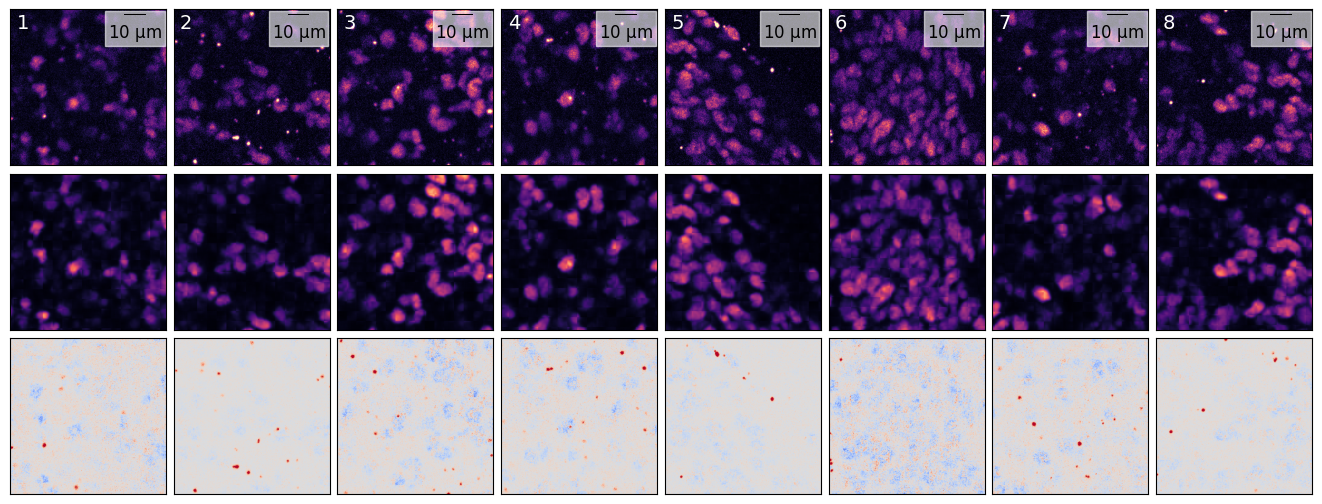

In [46]:
num_crops = len(hw_arr)
imgsz = 2.1
# hw_arr = [(np.random.randint(0, inp_region.shape[0] - cropsz), np.random.randint(0, inp_region.shape[1] - cropsz)) for _ in range(num_crops)]

_, ax = plt.subplots(figsize=(num_crops * imgsz, 3 * imgsz), ncols=num_crops, nrows=3)
for i, (h, w) in enumerate(hw_arr):
    print(f"{h},{w}")
    inp_crop = inp_region[h : h + cropsz, w : w + cropsz]
    ax[0, i].imshow(inp_crop, vmin=vmin, vmax=vmax, cmap="magma")
    ax[0, i].text(10, 30, str(i + 1), color="white", fontsize=14)
    scalebar = ScaleBar(
        resolution_nm,
        "nm",
        # length_fraction=0.1,
        box_alpha=0.6,
        frameon=True,
        location="upper right",
        font_properties={"size": 12},
    )

    ax[0, i].add_artist(scalebar)

    pred_crop = pred_region[h : h + cropsz, w : w + cropsz]
    # ax[1,i].imshow(np.stack([pred_crop,pred_crop,pred_crop], axis=-1),vmin=vmin/vmax, cmap='gray')
    ax[1, i].imshow(pred_crop, vmin=vmin, vmax=vmax, cmap="magma")
    diff_img = inp_crop - pred_crop
    # vmin_diff = min(diff_img.min(), -1*diff_img.max())
    vmax_diff = max(np.quantile(diff_img, 0.999), -1 * diff_img.min())
    vmin_diff = -1 * vmax_diff
    # vmin
    ax[2, i].imshow(inp_crop - pred_crop, cmap="coolwarm", vmin=vmin_diff, vmax=vmax_diff)
    clean_ax(ax[:, i])
plt.subplots_adjust(wspace=0.05, hspace=0.05)
if save_to_file:
    fpath = os.path.join(output_dir, f"{fname_prefix}_crops.pdf")
    plt.savefig(fpath, dpi=300)
    print("Saved to", fpath)